In [1]:
import pandas as pd
import numpy as np
import requests
import time
from bs4 import BeautifulSoup # Most common library for dealing with html

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


import re


In [2]:
# Two columns to focus on (From YouTube):
# 1. What subreddit it comes from
# 2. Title and Description of what post it comes from

# df[['subreddit', 'selftext', 'title']].head()

In [3]:
personal_df = pd.DataFrame()
insufficient_data = True
epoch = 1632489845     # SG Time: Friday, September 24, 2021 9:24:05 PM
loop_count = 0

while insufficient_data:
    url = 'https://api.pushshift.io/reddit/search/submission'
    params = {
        'subreddit': 'personalfinance',
        'size': 100,
        'before': epoch,
    }
    
    old_epoch = epoch
    
    res = requests.get(url, params)
    
    # Sometimes, Error 502 occurs. To resolve, we request again (akin to refreshing page)
    while res.status_code != 200:
        time.sleep(0.5)
        res = requests.get(url, params)
        
    data = res.json()
    posts = data['data']
    full_data = pd.DataFrame(posts)
    
    # Selecting the columns we want
    selected_cols = full_data[['subreddit', 'title', 'selftext', 'created_utc']]
    
    # Dropping unusable selftext
    selected_cols = selected_cols.dropna(subset=['selftext'])
    selected_cols_clean = selected_cols.loc[(selected_cols['selftext'] != '[removed]')
                                            & (selected_cols['selftext'] != '[deleted]')
                                            & (selected_cols['selftext'] != '')]
    
    # Adding data to main dataframe
    personal_df = pd.concat(objs=[personal_df, selected_cols_clean], axis=0)
    
    # Dropping duplicates within the same subreddit
    personal_df.drop_duplicates(subset=['selftext'], inplace=True)
    
    # Checking length of main dataframe
    len(personal_df)
        
    # For checking only
    loop_count += 1
    print(loop_count, len(personal_df))
    
    # Setting new epoch for next loop as the earliest time created out of the 100 posts obtained
    epoch = personal_df['created_utc'].iloc[-1]
    
    # Error tracking: If this is true, it will result in infinite loop
    if old_epoch == epoch:
        print('SAME OLDEST POST. ONE INFINITE LOOP')
        insufficient_data = False
    
    if len(personal_df) >= 1100:
        insufficient_data = False
        

1 79
2 163
3 251
4 328
5 400
6 476
7 560
8 634
9 719
10 807
11 896
12 980
13 1060
14 1138


In [4]:
investing_df = pd.DataFrame()
insufficient_data = True
epoch = 1632489845     # SG Time: Friday, September 24, 2021 9:24:05 PM
loop_count = 0

while insufficient_data:
    url = 'https://api.pushshift.io/reddit/search/submission'
    params = {
        'subreddit': 'investing',
        'size': 100,
        'before': epoch,
    }
    
    old_epoch = epoch
    
    res = requests.get(url, params)
    
    # Sometimes, Error 502 occurs. To resolve, we request again (akin to refreshing page)
    while res.status_code != 200:
        time.sleep(0.5)
        res = requests.get(url, params)
        
    data = res.json()
    posts = data['data']
    full_data = pd.DataFrame(posts)
    
    # Selecting the columns we want
    selected_cols = full_data[['subreddit', 'title', 'selftext', 'created_utc']]
    
    # Dropping unusable selftext
    selected_cols = selected_cols.dropna(subset=['selftext'])
    selected_cols_clean = selected_cols.loc[(selected_cols['selftext'] != '[removed]')
                                            & (selected_cols['selftext'] != '[deleted]')
                                            & (selected_cols['selftext'] != '')]
    
    # Adding data to main dataframe
    investing_df = pd.concat(objs=[investing_df, selected_cols_clean], axis=0)
    
    # Dropping duplicates within the same subreddit
    investing_df.drop_duplicates(subset=['selftext'], inplace=True)
    
    # Checking length of main dataframe
    len(investing_df)
        
    # For checking only
    loop_count += 1
    print(loop_count, len(investing_df))
    
    # Setting new epoch for next loop as the earliest time created out of the 100 posts obtained
    epoch = investing_df['created_utc'].iloc[-1]
    
    # Error tracking: If this is true, it will result in infinite loop
    if old_epoch == epoch:
        print('SAME OLDEST POST. ONE INFINITE LOOP')
        insufficient_data = False
    
    if len(investing_df) >= 1100:
        insufficient_data = False
        

1 16
2 28
3 48
4 62
5 77
6 87
7 104
8 119
9 142
10 154
11 175
12 186
13 197
14 211
15 221
16 237
17 262
18 272
19 287
20 293
21 311
22 322
23 341
24 357
25 373
26 400
27 407
28 421
29 434
30 450
31 465
32 481
33 499
34 518
35 531
36 547
37 564
38 581
39 597
40 615
41 639
42 662
43 678
44 696
45 711
46 727
47 742
48 756
49 776
50 790
51 810
52 821
53 842
54 862
55 884
56 902
57 919
58 935
59 945
60 961
61 976
62 999
63 1019
64 1035
65 1053
66 1070
67 1093
68 1113


In [5]:
combined_df = pd.concat(objs=[investing_df, personal_df], axis=0)
combined_df.drop_duplicates(subset=['selftext'], inplace=True)
combined_df.reset_index(inplace=True, drop=True)
combined_df['subreddit'].value_counts()

personalfinance    1138
investing          1113
Name: subreddit, dtype: int64

In [32]:
tokenizer = RegexpTokenizer(r'\w+')
p_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def regex_sucks(row):
        
    # Remove links
    row['selftext'] = re.sub(
        pattern=r'\w+:\/\/[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', 
        repl='', 
        string=row['selftext'],
        flags=re.M)
    
    # Remove subreddit name 'investing'
    row['selftext'] = re.sub(
        pattern=r'investing',
        repl='',
        string=row['selftext'],
        flags=re.I)

    # Remove subreddit name 'personalfinance'
    row['selftext'] = re.sub(
        pattern=r'personalfinance',
        repl='',
        string=row['selftext'],
        flags=re.I)
    
    # Remove all digits
    row['selftext'] = re.sub(
        pattern=r'\d+',
        repl='',
        string=row['selftext'])
    
    # Remove all special characters from selftext
    row['selftext'] = re.sub(
        pattern=r'\W+',
        repl=' ',
        string=row['selftext'])
    
#    # Tokenize
#     row['selftext'] = [tok for tok in tokenizer.tokenize(row['selftext'].lower())]
    
#    # Stemming
#     row['selftext'] = [p_stemmer.stem(tok) for tok in row['selftext']]
        
#     # Drop english stop words
#     row['selftext'] = [tok for tok in row['selftext'] if tok not in stopwords.words('english')]
    
    return row
    
clean_df = combined_df.apply(regex_sucks, axis=1)

# Binarize column 'subreddit' where 'investing' == 1, 'personalfinance' == 0
clean_df['subreddit'] = clean_df['subreddit'].map(lambda x: 1 if x == 'investing' else 0)
clean_df.drop(columns=['created_utc'], inplace=True)

In [22]:
def toklem(x):
    tok_lem = [p_stemmer.stem(token) for token in tokenizer.tokenize(x.lower()) if token not in stopwords.words('english')]
    return ' '.join(tok_lem)
clean_df['tok_stem'] = clean_df['selftext'].apply(toklem)

In [ ]:
tokstem_text = []
def tok_stem(row):
    for token in tokenizer.tokenize(row['selftext'].lower()):
        tokstem_text = []
        if token not in stopwords.words('english'):
            tokstem_text.append(p_stemmer.stem(token))
        row['tok_stem_text'] = ' '.join(tokstem_text)
    return row

clean_df = clean_df.apply(tok_stem, axis=1)


In [30]:
tokstem = []
def tok_stem(text):
    for token in tokenizer.tokenize(text.lower()):
        if token not in stopwords.words('english'):
            tokstem.append(p_stemmer.stem(token))
    return ' '.join(tokstem)

clean_df['tok_stem'] = clean_df['selftext'].apply(tok_stem)


In [ ]:
clean_df

In [8]:
clean_df

,subreddit,title,selftext,tok_lem
0,1,I have 4 begginer level questions about stocks...,First is about the bid ask spread if the bid i...,first bid ask spread bid dollar ask bidder sti...
1,1,Should you follow insider transactions? - I an...,There is an old saying on Wall Street gt There...,old saying wall street gt many possible reason...
2,1,Value investment for the rebound?,I am a value investor a like buying cheap stuf...,value investor like buying cheap stuff bloombe...
3,1,Daily General Discussion and spitballin thread...,Have a general question Want to offer some com...,general question want offer commentary market ...
4,1,Daily Advice Thread - All basic help or advice...,If your question is I have what do I do or oth...,question advice personal situation question in...
...,...,...,...,...
2246,0,An insurance company has been taking money out...,Backstory My parents aren t great with online ...,backstory parent great online banking noticed ...
2247,0,How do I prove lack of income?,I m an adult living with my parents who cover ...,adult living parent cover expense recently hos...
2248,0,Home equity loan for vacation rental and college?,Mid s married w kids Own home worth approx k o...,mid married w kid home worth approx k owe k re...
2249,0,Current refi rates?,Has anyone refinance recently in Georgia I am ...,anyone refinance recently georgia getting clos...


In [9]:
clean_df['selftext'][0]

'First is about the bid ask spread if the bid is dollars and the ask is the bidder will still pay dollars and the ask will receive correct So what is the point of the bidder doing a bid if he is going to pay the full amount Does he choose how much money goes to spread and how much to the seller The second question is how is it beneficial in the long term for a company to give shares if the profits are going to shareholders The third question is about crypto why would crypto be in demand if we can just use regular currency The fourth question is about stock dividends if a company pays you in stocks instead of money how would you make money from that '

In [10]:
old_clean_df = clean_df

In [11]:
# Baseline: 50.6% from personalfinance

clean_df['subreddit'].value_counts(normalize=True)

0    0.505553
1    0.494447
Name: subreddit, dtype: float64

# Step 1: Tokenize --> DONE
## 1. Regex
# Step 2: Porter Stem --> DONE
# Step 3: Drop Stop Words --> DONE
# Step 4: CVEC
## 1. Do some EDA
# Step 5: Random Forest


In [12]:
# Instantiate CountVectorizer()
cvec = CountVectorizer()

X = clean_df[['title', 'selftext']]
y = clean_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  random_state=42,
                                                  stratify=y
                                                 )

In [13]:
X_train_corp = cvec.fit_transform(X_train)
X_test_corp = cvec.transform(X_test)

<AxesSubplot:>

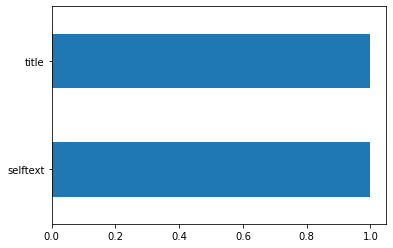

In [14]:
X_train_df = pd.DataFrame(X_train_corp.todense(), 
                       columns=cvec.get_feature_names())

X_train_df.sum().sort_values(ascending=False).head(20).plot(kind='barh')
